# <center> What is a Feature ? <br><br> Research Question: What is the Frequency of Feature Issue Creation in Different Phases of Software Development and What is the Average Lifespan of a Feature Issue?</center>

### Glossary

<b>Feature Label</b>: a label that contains the word "feature". <br>
<b>Feature Issue</b>: an issue that has at least one <b>feature label</b>. <br>
<b>Feature Issue Dataset</b>: a dataset containing a number of <b>feature issues</b>. Each feature issue is associated with the repository it comes from through the "repository name" column.

### Importing Required Libraries

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import numpy as np
import os

### Importing Appropriate DataSets

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

#pd.reset_option('max_columns')
pd.reset_option('max_colwidth')
pd.reset_option('max_rows')

def combine_partial_datasets(folder_path):
    # Get a list of all files in the specified folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

df_issues = combine_partial_datasets('../../dataset/issues/partial_datasets/')
df_repos = pd.read_csv('../../dataset/repositories/filtered/full_feature_label_dataset.csv')

print('Issue Dataframe Shape:', df_issues.shape)
print('Repository Dataframe Shape:', df_repos.shape)
df_repos.head(2)

Issue Dataframe Shape: (265089, 14)
Repository Dataframe Shape: (45702, 34)


,id,name,isFork,commits,branches,defaultBranch,releases,contributors,license,watchers,stargazers,forks,size,createdAt,pushedAt,updatedAt,homepage,mainLanguage,totalIssues,openIssues,totalPullRequests,openPullRequests,blankLines,codeLines,commentLines,metrics,lastCommit,lastCommitSHA,hasWiki,isArchived,languages,labels,topics,feature_labels
0,0,sparklemotion/nokogiri,False,7013.0,36.0,main,55.0,221.0,MIT License,161.0,6060,920,36571,2008-07-14 03:34:32,2023-09-09 09:24:35,2023-09-10 11:50:36,https://nokogiri.org/,C,1907.0,100.0,972.0,22.0,13510,124494,14034,"[{'blankLines': 0, 'language': 'XHTML', 'comme...",2023-09-09T09:24:34,7617e46e5d3787cfc03bb3b4611de5fbfbe5d954,NaN,NaN,"{'C': 1419258, 'Ruby': 1165989, 'Java': 660613...","['backport', 'blocked', 'dependencies', 'githu...","['libxml2', 'libxslt', 'nokogiri', 'ruby', 'ru...",['meta/feature-request']
1,61,davidb/scala-maven-plugin,False,1078.0,8.0,master,0.0,58.0,The Unlicense,23.0,541,148,6372,2008-05-31 09:02:12,2023-09-04 06:04:53,2023-09-05 02:09:33,https://davidb.github.io/scala-maven-plugin/,Java,273.0,4.0,441.0,9.0,1201,11162,1399,"[{'blankLines': 44, 'language': 'CSS', 'commen...",2023-07-24T08:08:29,729e31c2e9492606c83d45fad7350a5f707af5cf,NaN,NaN,"{'Java': 226712, 'CSS': 8764, 'Groovy': 6446, ...","['2.12-release', '2.13-release', '2.14-release...",[],['feature-request']


In [27]:
df_issues.head(2)

,repositoryName,issueTitle,issueBody,issueNumber,issueState,issueCreatedAt,issueUpdatedAt,issueClosedAt,issueUser,assignee,issueLabels,milestone,comments,commentsURL
0,aws/aws-tools-for-powershell,Disable TLS Certificate Check,### Describe the feature\n\nIssue previously r...,334,open,2023-11-27 07:25:10+00:00,2023-12-08 18:20:22+00:00,NaN,BoneyAz,Not assigned,"['feature-request', 'module/powershell-cmdlets...",No milestone,2,https://api.github.com/repos/aws/aws-tools-for...
1,aws/aws-tools-for-powershell,Add support for IAM Identity Center (SSO) auth...,### Describe the feature\r\n\r\nImplement nati...,332,open,2023-08-18 18:04:46+00:00,2023-08-25 16:33:08+00:00,NaN,dbaileyut,Not assigned,"['feature-request', 'module/powershell-cmdlets...",No milestone,2,https://api.github.com/repos/aws/aws-tools-for...


## 1) Analysing the Average and Median Lifespan of a Feature Issue

In [13]:
def compute_stats_lifespan(closed_issues_df):
    ## Create a copy of the DataFrame to avoid SettingWithCopyWarning
    closed_issues_df = closed_issues_df.copy()

    # Convert 'issueCreatedAt' and 'issueClosedAt' columns to datetime objects
    closed_issues_df['issueCreatedAt'] = pd.to_datetime(closed_issues_df['issueCreatedAt'])
    closed_issues_df['issueClosedAt'] = pd.to_datetime(closed_issues_df['issueClosedAt'])

    # Calculate the lifespan for each closed issue
    closed_issues_df['lifespan'] = closed_issues_df['issueClosedAt'] - closed_issues_df['issueCreatedAt']

    # Compute the average
    average_lifespan = closed_issues_df['lifespan'].mean()

    # Compute the median
    median_lifespan = closed_issues_df['lifespan'].median()

    # Format the results
    def format_lifespan(lifespan):
        days = lifespan.days
        hours, remainder = divmod(lifespan.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days and {hours}h{minutes}m{seconds}s"

    formatted_average = format_lifespan(average_lifespan)
    formatted_median = format_lifespan(median_lifespan)

    return formatted_average, formatted_median

closed_issues = df_issues[df_issues['issueState'] == 'closed']

average_lifespan, median_lifespan = compute_stats_lifespan(closed_issues)

print(f"For {closed_issues.shape[0]} of closed feature issues in our dataset:\n")
print(f"\t=> The average lifespan is {average_lifespan}")
print(f"\t=> The median lifespan is {median_lifespan}")

For 192147 of closed feature issues in our dataset:

	=> The average lifespan is 156 days and 8h1m24s
	=> The median lifespan is 39 days and 10h38m4s


## 2) Analysing "Feature Issue" Creation Frequency in Different Phases of Development

In [14]:
number_of_phases = 5

### Enhancing Issues Dataframe with Further Information about Creation and Update Times of Repositories

In [15]:
df_issues_enhanced = df_issues.merge(df_repos[['name', 'createdAt', 'updatedAt']], left_on='repositoryName', right_on='name', how='left')

# Drop the redundant 'name' column
df_issues_enhanced = df_issues_enhanced.drop(columns=['name'])

# Rename columns to make them more readable
df_issues_enhanced = df_issues_enhanced.rename(columns={'createdAt': 'repoCreatedAt', 'updatedAt': 'repoUpdatedAt'})

df_issues_enhanced.head(2)

,repositoryName,issueTitle,issueBody,issueNumber,issueState,issueCreatedAt,issueUpdatedAt,issueClosedAt,issueUser,assignee,issueLabels,milestone,comments,commentsURL,repoCreatedAt,repoUpdatedAt
0,aws/aws-tools-for-powershell,Disable TLS Certificate Check,### Describe the feature\n\nIssue previously r...,334,open,2023-11-27 07:25:10+00:00,2023-12-08 18:20:22+00:00,NaN,BoneyAz,Not assigned,"['feature-request', 'module/powershell-cmdlets...",No milestone,2,https://api.github.com/repos/aws/aws-tools-for...,2019-03-26 05:41:43,2023-09-04 10:07:41
1,aws/aws-tools-for-powershell,Add support for IAM Identity Center (SSO) auth...,### Describe the feature\r\n\r\nImplement nati...,332,open,2023-08-18 18:04:46+00:00,2023-08-25 16:33:08+00:00,NaN,dbaileyut,Not assigned,"['feature-request', 'module/powershell-cmdlets...",No milestone,2,https://api.github.com/repos/aws/aws-tools-for...,2019-03-26 05:41:43,2023-09-04 10:07:41


### Converting Timestamps to the Right Format

In [16]:
df_issues_enhanced['issueCreatedAt'] = pd.to_datetime(df_issues_enhanced['issueCreatedAt'])
df_issues_enhanced['repoCreatedAt'] = pd.to_datetime(df_issues_enhanced['repoCreatedAt'])
df_issues_enhanced['repoUpdatedAt'] = pd.to_datetime(df_issues_enhanced['repoUpdatedAt'])

### Analysing Weighted & Unweighted Average Feature Issue Creation Frequencies 

In [17]:
# Function to calculate creation frequency by phases
def get_creation_frequency_by_phases(start_timestamp, end_timestamp, timestamps_series, n=5):
    total_range = end_timestamp - start_timestamp
    interval = total_range / n
    intervals = [start_timestamp + i * interval for i in range(n)] + [end_timestamp]

    # Convert timestamps_series to the same time zone as intervals
    timestamps_series = timestamps_series.dt.tz_localize(start_timestamp.tz)

    # Count the number of timestamps in each interval
    counts = []
    for i in range(n):
        count = ((timestamps_series >= intervals[i]) & (timestamps_series < intervals[i+1])).sum()
        percentage = (count / len(timestamps_series)) * 100
        rounded_percentage = round(percentage, 2)
        counts.append(rounded_percentage)
    counts.append(len(timestamps_series))

    return counts

# Function to get issue creation frequencies for each repository
def get_issue_creation_frequencies(df_issues_enhanced, nb_phases=5):
    issue_creation_frequency_lists = []
    repository_names = df_issues_enhanced['repositoryName'].unique().tolist()

    for repository in repository_names:
        # Filter dataframe for the specific repository
        repository_df = df_issues_enhanced[df_issues_enhanced['repositoryName'] == repository]
        
        # Check if there are entries for the repository
        if not repository_df.empty:
            start = repository_df['repoCreatedAt'].iloc[0]
            end = repository_df['repoUpdatedAt'].iloc[0]
            issue_creation_timestamps = repository_df['issueCreatedAt']
            issue_creation_frequencies_for_repo = get_creation_frequency_by_phases(start, end, issue_creation_timestamps, nb_phases)
            issue_creation_frequency_lists.append(issue_creation_frequencies_for_repo)
    
    return issue_creation_frequency_lists

# Function to compute the weighted average
def compute_weighted_average(list_of_lists):
    array_of_lists = np.array(list_of_lists)
    percentages = array_of_lists[:, :-1]
    weights = array_of_lists[:, -1]
    weighted_sums = np.sum(percentages * weights[:, np.newaxis], axis=0)
    total_weight = np.sum(weights)
    weighted_avg = weighted_sums / total_weight
    
    return weighted_avg

# Function to compute the unweighted average
def compute_unweighted_average(list_of_lists):
    array_of_lists = np.array(list_of_lists)
    percentages = array_of_lists[:, :-1]
    avg = np.mean(percentages, axis=0)
    
    return avg

issue_creation_frequency_lists = get_issue_creation_frequencies(df_issues_enhanced, number_of_phases)

weighted_average_of_issue_creation_frequencies = np.round(compute_weighted_average(issue_creation_frequency_lists), 2)
unweighted_average_of_issue_creation_frequencies = np.round(compute_unweighted_average(issue_creation_frequency_lists), 2)

### Results

In this part of the analysis, we consider that a project's development can be divided into 5 phases. We then analyse the frequency of feature-issue creation in each phase for 3643 repositories (in %).

When considering the weight of a repository (measured by the number of feature-issues it contains we get the following results:

	=> Phase 0: 18.83%
	=> Phase 1: 19.02%
	=> Phase 2: 20.67%
	=> Phase 3: 18.36%
	=> Phase 4: 16.74%


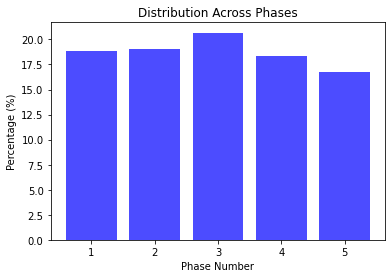


Without considering weights, we get:

	=> Phase 0: 30.35%
	=> Phase 1: 20.7%
	=> Phase 2: 17.23%
	=> Phase 3: 14.79%
	=> Phase 4: 12.37%


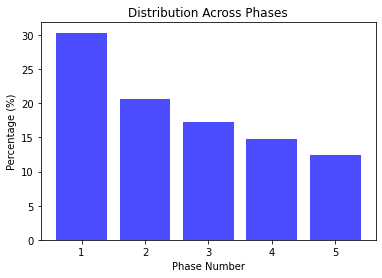

In [18]:
def plot_percentage_bar_chart(percentage_list):
    # Number of phases
    num_phases = len(percentage_list)

    # Create x-axis values (phase numbers)
    x_values = range(1, num_phases + 1)

    # Plot the bar chart
    plt.bar(x_values, percentage_list, color='blue', alpha=0.7)
    
    # Set labels and title
    plt.xlabel('Phase Number')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution Across Phases')

    # Show the plot
    plt.show()

nb_repos = len(df_issues_enhanced['repositoryName'].unique().tolist())
print(f"In this part of the analysis, we consider that a project's development can be divided into {number_of_phases} phases. We then analyse the frequency of feature-issue creation in each phase for {nb_repos} repositories (in %).\n")
print(f"When considering the weight of a repository (measured by the number of feature-issues it contains we get the following results:\n")

for i, freq in enumerate(weighted_average_of_issue_creation_frequencies):
    print(f"\t=> Phase {i}: {freq}%")
    
plot_percentage_bar_chart(weighted_average_of_issue_creation_frequencies)
    
print(f"\nWithout considering weights, we get:\n")

for i, freq in enumerate(unweighted_average_of_issue_creation_frequencies):
    print(f"\t=> Phase {i}: {freq}%")
    
plot_percentage_bar_chart(unweighted_average_of_issue_creation_frequencies)

### Analysing the Distributions of Feature Issue Creation Frequencies for Different Phases of Development 

In [19]:
def plot_repository_frequencies(issue_creation_frequency_lists):
    # Convert the list of lists to a NumPy array
    array_of_lists = np.array(issue_creation_frequency_lists)
    
    # Extract percentages and weights
    percentages = array_of_lists[:, :-1]
    weights = array_of_lists[:, -1]

    # Number of phases and repositories
    num_phases = percentages.shape[1]
    num_repositories = percentages.shape[0]

    # Create subplots for each phase with a larger figure size
    fig, axes = plt.subplots(nrows=num_phases, ncols=1, figsize=(12, 18), sharex=True)
    fig.suptitle('Repository Feature Issue Creation Frequencies for Each Phase', fontsize=16)

    # Plot bar charts for each phase with adjusted colors and alpha
    for i in range(num_phases):
        phase_values = percentages[:, i]
        axes[i].bar(np.arange(num_repositories), phase_values, color='skyblue', alpha=0.8, edgecolor='black', linewidth=0.7)
        axes[i].set_ylabel(f'Phase {i + 1} Frequency (%)', fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Set x-axis ticks and labels with larger font size
    #plt.xticks(np.arange(num_repositories), range(1, num_repositories + 1), fontsize=12)
    plt.xlabel('Repository', fontsize=14)

    # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()
    
def plot_phase_histograms(issue_creation_frequency_lists):
    # Convert the list of lists to a NumPy array
    array_of_lists = np.array(issue_creation_frequency_lists)
    
    # Extract percentages and weights
    percentages = array_of_lists[:, :-1]
    weights = array_of_lists[:, -1]

    # Number of phases
    num_phases = percentages.shape[1]

    # Create subplots for each phase
    fig, axes = plt.subplots(nrows=1, ncols=num_phases, figsize=(15, 5), sharey=True)
    fig.suptitle('Distribution of Frequencies for Each Phase')

    # Plot histograms for each phase
    for i in range(num_phases):
        phase_values = percentages[:, i]
        axes[i].hist(phase_values, bins=10, color='blue', alpha=0.7)
        axes[i].set_title(f'Phase {i + 1}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel('Count')

    plt.show()

### Results

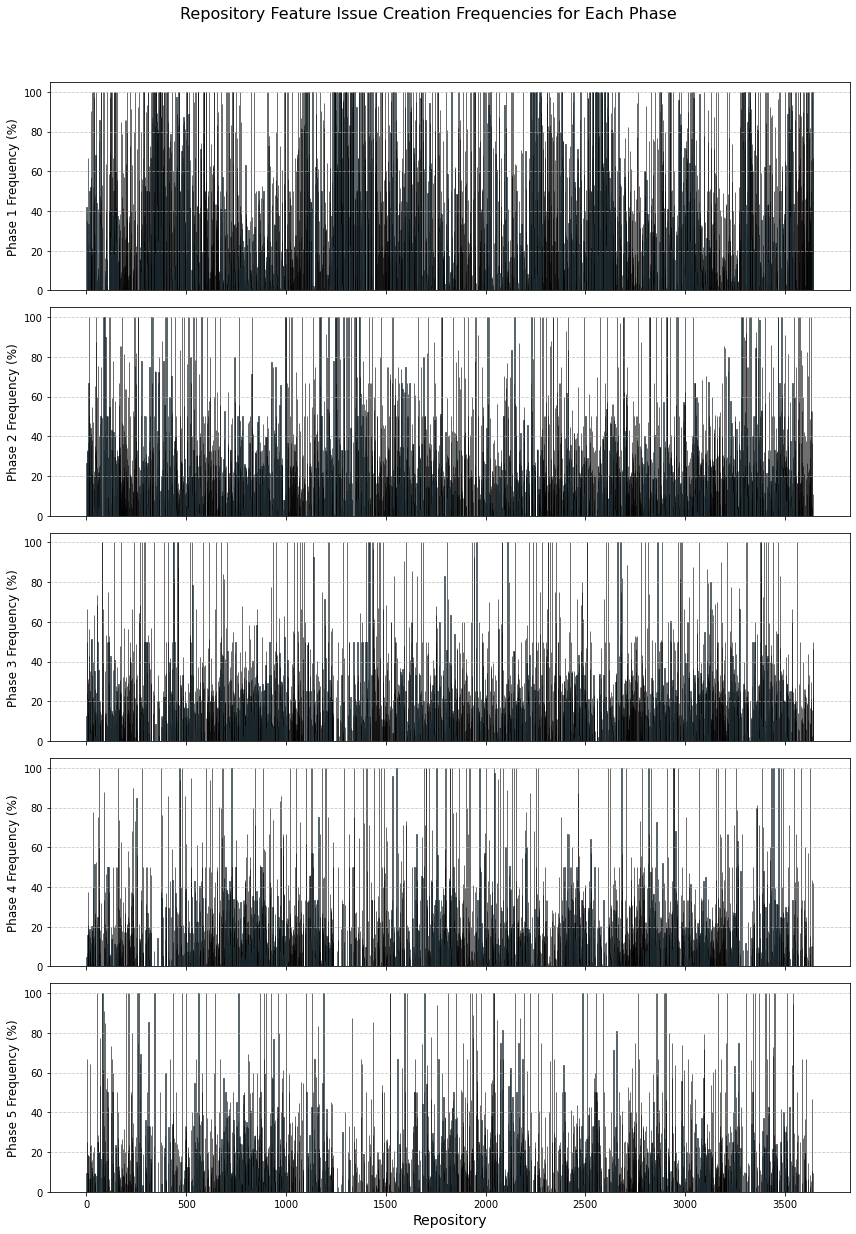

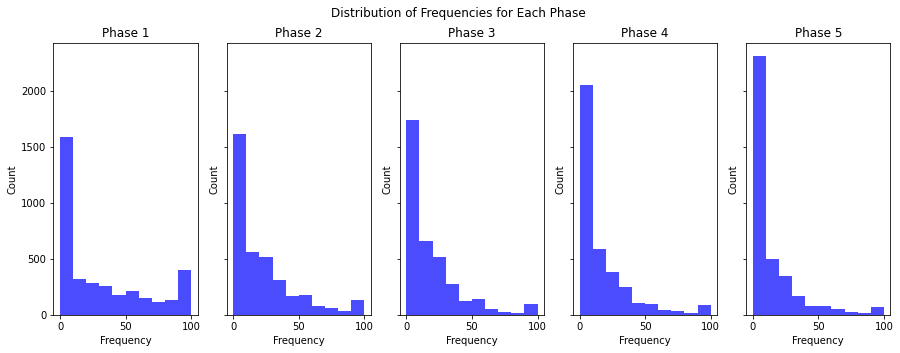

In [20]:
plot_repository_frequencies(issue_creation_frequency_lists)
plot_phase_histograms(issue_creation_frequency_lists)